In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [5]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

In [ ]:
# For the CDF functions, we need to generate a dataset of new examples
S_new = GeneratedDataset(10*m)

## NN Model

In [6]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [7]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [9]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
        

In [10]:
class SingleAlphabetNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetNet, self).__init__()
        self.name = "SingleAlphabetNet"
        
        self.cnn_1 = nn.Conv1d(24, 25, 3) 
        self.cnn_2 = nn.Conv1d(25, 50, 3)
        self.cnn_3 = nn.Conv1d(50, 100, 3)
        self.cnn_4 = nn.Conv1d(100, 200, 3)
        self.cnn_5 = nn.Conv1d(200, 400, 1)
        self.cnn_6 = nn.Conv1d(400, 800, 1)
        
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))        

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [11]:
class SingleAlphabetComplexNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetComplexNet, self).__init__()
        self.name = "SingleAlphabetComplexNet"
        
        self.cnn_1 = nn.Conv1d(24, 50, 3) 
        self.cnn_2 = nn.Conv1d(50, 100, 3)
        self.cnn_3 = nn.Conv1d(100, 200, 3)
        self.cnn_4 = nn.Conv1d(200, 400, 3)
        self.cnn_5 = nn.Conv1d(400, 800, 3)
        self.cnn_6 = nn.Conv1d(800, 1000, 3, padding=2)
        self.cnn_7 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_8 = nn.Conv1d(800, 700, 3, padding=2)
        self.cnn_9 = nn.Conv1d(700, 500, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))
        pair = self.pool1(self.relu(self.cnn_7(pair))) 
        pair = self.pool1(self.relu(self.cnn_8(pair)))
        pair = self.pool1(self.relu(self.cnn_9(pair))) 

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [33]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') #(40, 4)
        pep = one_hot(pep, seq_type='peptide') #(8, 20)
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

#Returns area under the CDF
def auc_cdf(train, new): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    plt.xlim([0,1])
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [36]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None, 
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] + 1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9, last_epoch=-1) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            
            if label == 0.0:
                train_gen_scores.append(train_score.item())
            elif label == 1.0:
                train_scores.append(train_score.item())
                
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
            
            if cdf:
                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    if single_alphabet:
                        p_val, l_val = convert(x, y, 0, single_alphabet=True)
                        gen_score = model(p_val)
                    else:
                        a_val, p_val, l_val = convert(x, y, 0)
                        gen_score = model(a_val, p_val)
                    gen_outputs.append(gen_score.item())

                # Generate CDF plots
                if len(train_scores) > 1000:
                    train_cdf = np.asarray(gen_outputs[-10000:] + train_scores[-1000:]) 
                    test_cdf = np.asarray(gen_outputs[-10000:] + val_scores[-1000:])
                else:
                    train_cdf = np.asarray(gen_outputs + train_scores) #combine train and unknown scores
                    test_cdf = np.asarray(gen_outputs + val_scores)
            
            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-100:]), sorted(val_gen_scores[-1000:]))
                train_auc = auc_cdf(sorted(train_scores[-100:]), sorted(train_gen_scores[-1000:]))
                print("Training AUC at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation AUC epoch %d: {}".format(val_auc) % full_epoch)
    
                if cdf:
                    plot_ecdf_train(train_cdf, iters, full_epoch, lr, model_name, model_id)
                    plot_ecdf_test(test_cdf, iters, full_epoch, lr, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) % full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) % full_epoch)
        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 20/946094 [00:00<1:21:35, 193.24it/s]

Reloading model:  SingleAlphabetComplexNet  at epoch:  38
Starting epoch: 38  with learning rate:  [0.1]


  5%|▌         | 49999/946094 [06:29<1:40:02, 149.28it/s]

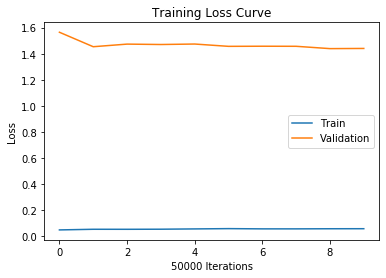

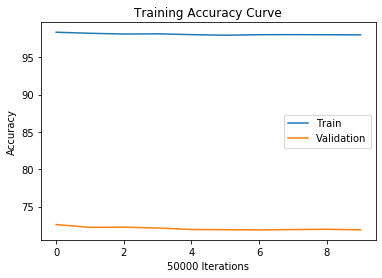

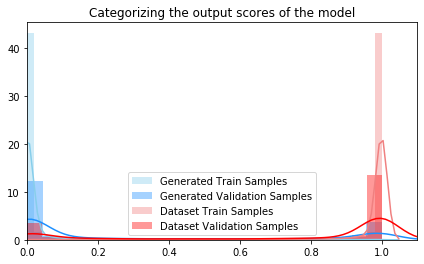

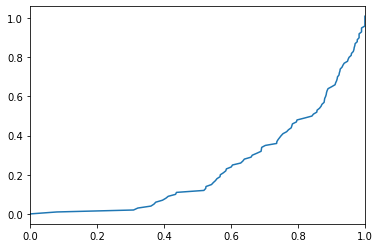

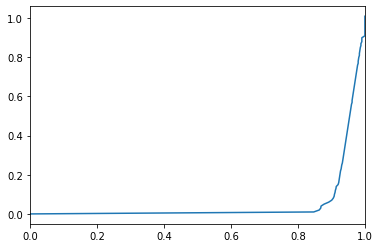

  5%|▌         | 50017/946094 [06:33<15:52:08, 15.69it/s]

Training AUC at epoch 38: 0.05300909090909091
Validation AUC epoch 38: 0.2375818181818182
Training Accuracy at epoch 38: 97.992
Validation Accuracy epoch 38: 71.9


 11%|█         | 99995/946094 [13:10<2:11:00, 107.64it/s]

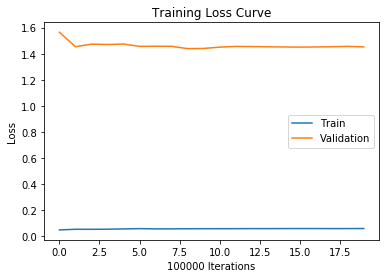

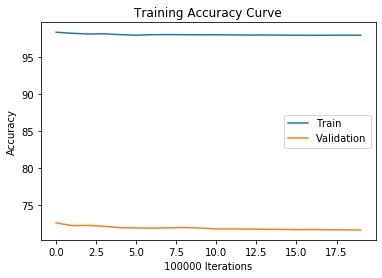

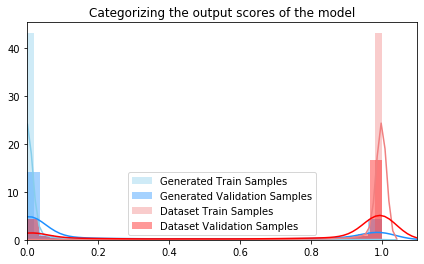

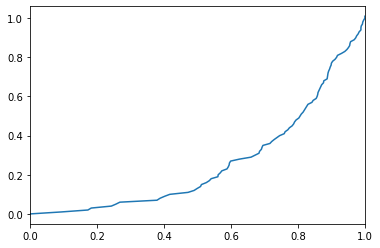

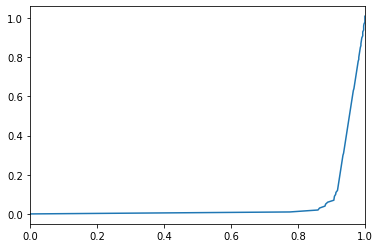

 11%|█         | 100027/946094 [13:13<11:18:35, 20.78it/s]

Training AUC at epoch 38: 0.054109090909090905
Validation AUC epoch 38: 0.2608727272727273
Training Accuracy at epoch 38: 97.931
Validation Accuracy epoch 38: 71.65


 16%|█▌        | 149985/946094 [19:53<1:24:07, 157.74it/s]

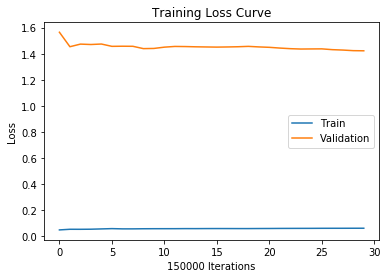

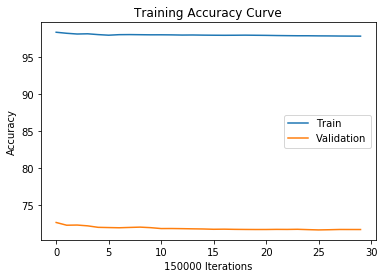

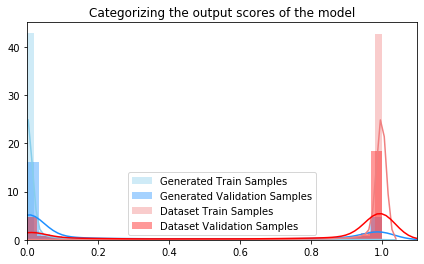

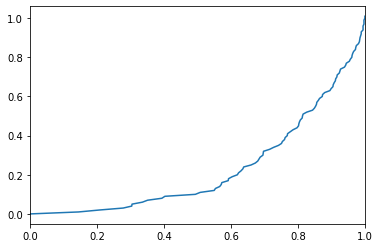

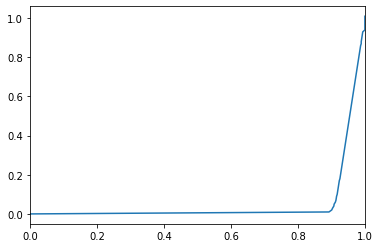

 16%|█▌        | 150003/946094 [19:57<16:12:12, 13.65it/s]

Training AUC at epoch 38: 0.05041818181818182
Validation AUC epoch 38: 0.23024545454545453
Training Accuracy at epoch 38: 97.81133333333334
Validation Accuracy epoch 38: 71.648


 21%|██        | 199987/946094 [26:34<1:41:09, 122.93it/s]

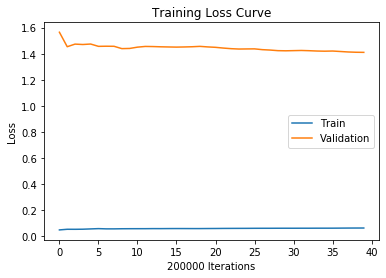

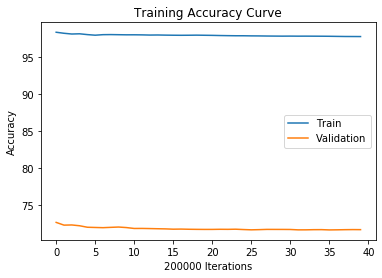

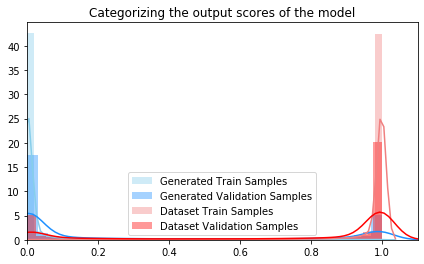

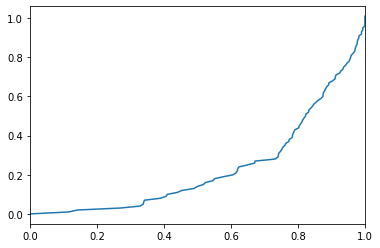

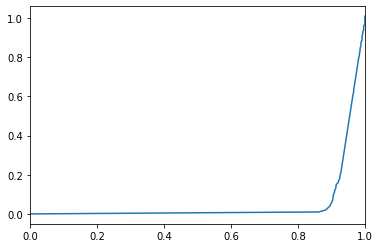

 21%|██        | 200020/946094 [26:38<11:35:04, 17.89it/s]

Training AUC at epoch 38: 0.0523
Validation AUC epoch 38: 0.234
Training Accuracy at epoch 38: 97.7565
Validation Accuracy epoch 38: 71.6185


 26%|██▋       | 249984/946094 [33:15<2:01:41, 95.33it/s] 

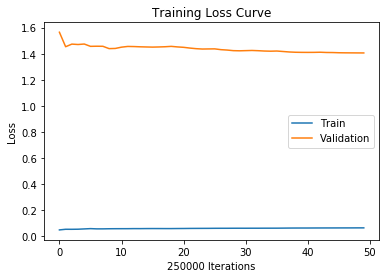

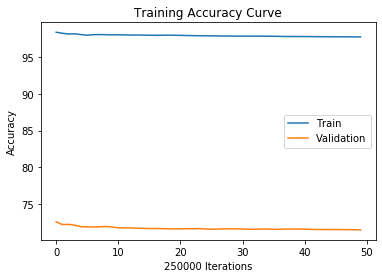

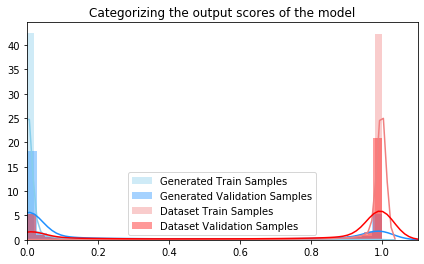

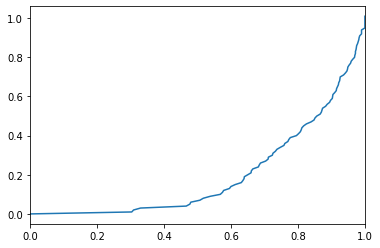

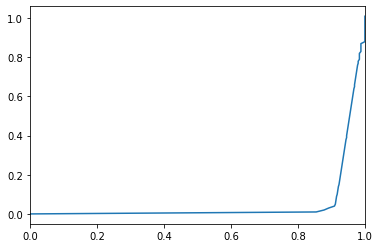

 26%|██▋       | 250020/946094 [33:19<13:08:34, 14.71it/s]

Training AUC at epoch 38: 0.05037272727272727
Validation AUC epoch 38: 0.19839999999999997
Training Accuracy at epoch 38: 97.7088
Validation Accuracy epoch 38: 71.5028


 32%|███▏      | 299987/946094 [39:56<1:11:55, 149.71it/s]

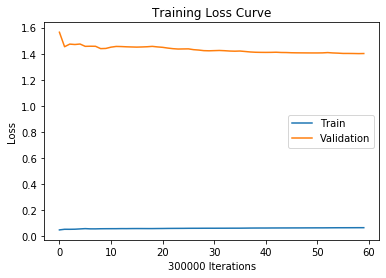

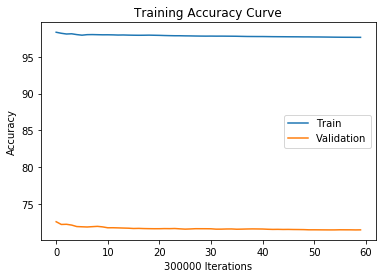

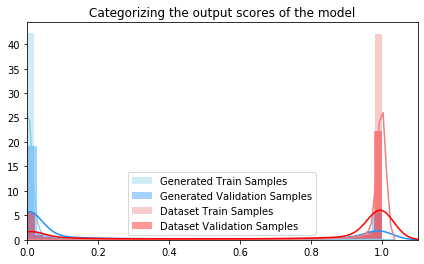

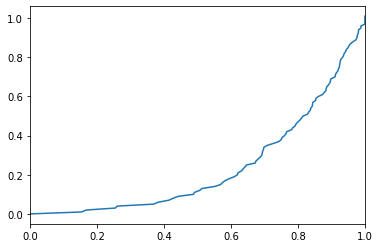

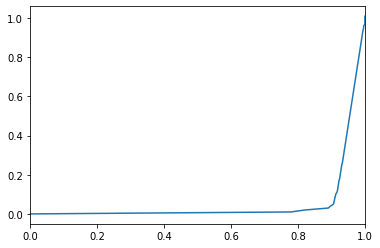

 32%|███▏      | 300023/946094 [40:02<11:17:34, 15.89it/s]

Training AUC at epoch 38: 0.05310000000000001
Validation AUC epoch 38: 0.23809090909090908
Training Accuracy at epoch 38: 97.648
Validation Accuracy epoch 38: 71.49566666666666


 37%|███▋      | 349999/946094 [46:36<1:20:34, 123.30it/s]

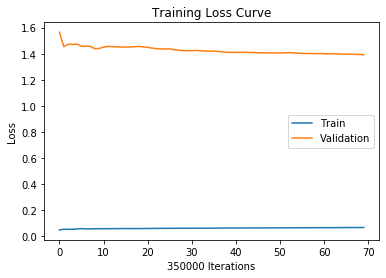

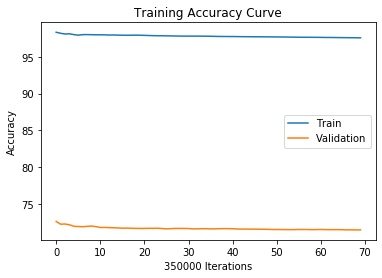

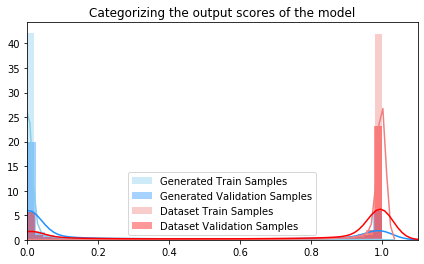

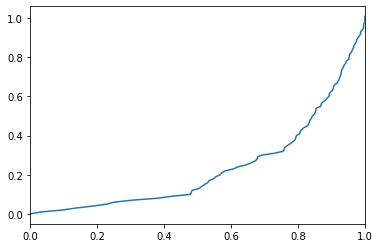

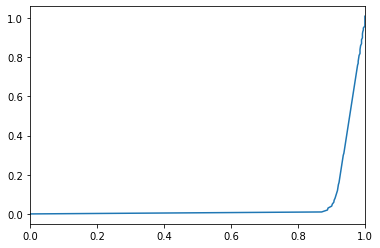

 37%|███▋      | 350016/946094 [46:41<15:05:21, 10.97it/s]

Training AUC at epoch 38: 0.0513909090909091
Validation AUC epoch 38: 0.2359
Training Accuracy at epoch 38: 97.58
Validation Accuracy epoch 38: 71.45057142857142


 12%|█▏        | 115607/946094 [16:11<1:32:07, 150.25it/s]

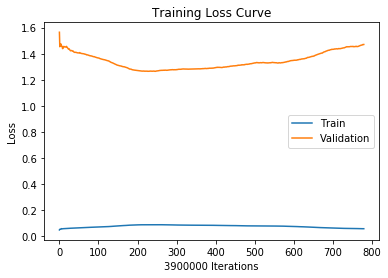

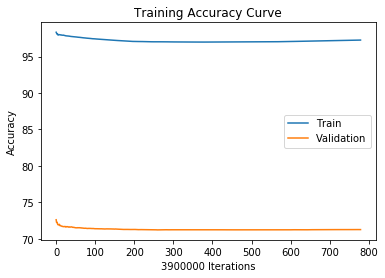

 12%|█▏        | 115607/946094 [16:30<1:32:07, 150.25it/s]

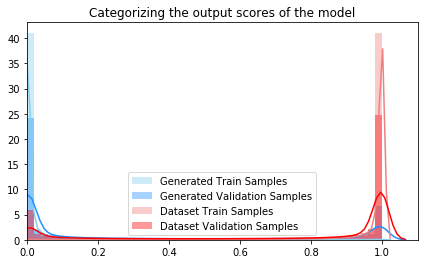

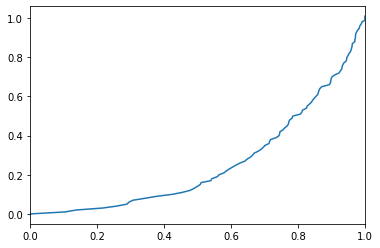

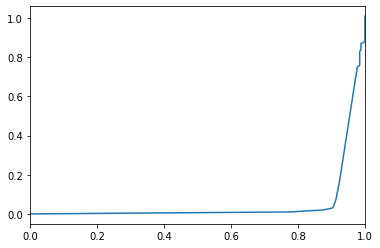

 12%|█▏        | 115642/946094 [16:39<80:17:53,  2.87it/s] 

Training AUC at epoch 42: 0.051054545454545464
Validation AUC epoch 42: 0.25744545454545453
Training Accuracy at epoch 42: 97.2643076923077
Validation Accuracy epoch 42: 71.24723076923077


 17%|█▋        | 163421/946094 [23:06<2:06:26, 103.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 33%|███▎      | 315622/946094 [45:03<1:48:23, 96.94it/s] 

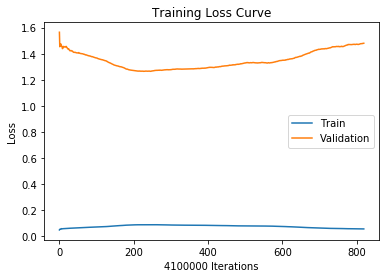

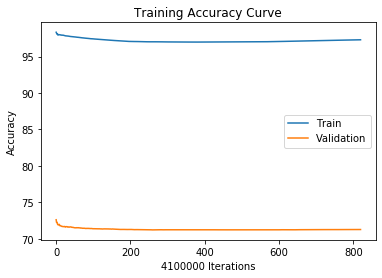

 33%|███▎      | 315622/946094 [45:20<1:48:23, 96.94it/s]

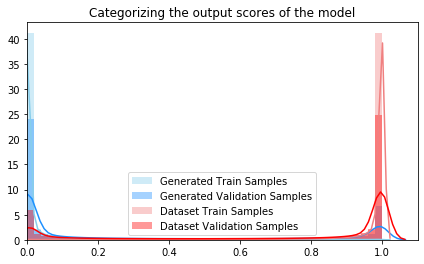

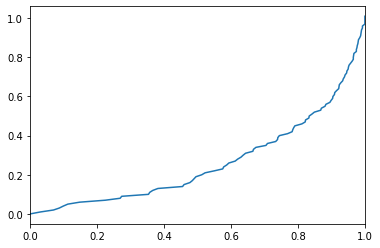

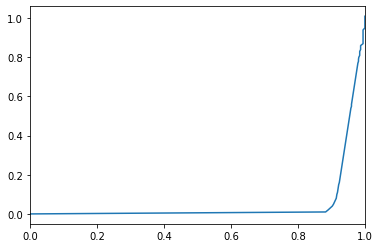

 33%|███▎      | 315640/946094 [45:33<546:39:18,  3.12s/it]

Training AUC at epoch 42: 0.05053636363636364
Validation AUC epoch 42: 0.26111818181818186
Training Accuracy at epoch 42: 97.30421951219512
Validation Accuracy epoch 42: 71.2570487804878


 36%|███▌      | 338282/946094 [48:33<1:33:56, 107.83it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 465607/946094 [1:06:15<47:23, 168.97it/s]  

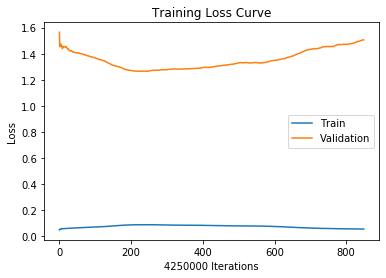

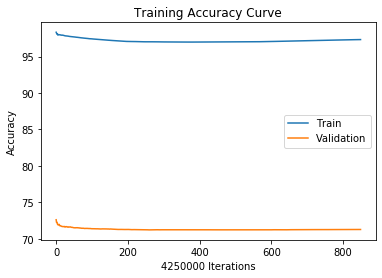

 49%|████▉     | 465607/946094 [1:06:30<47:23, 168.97it/s]

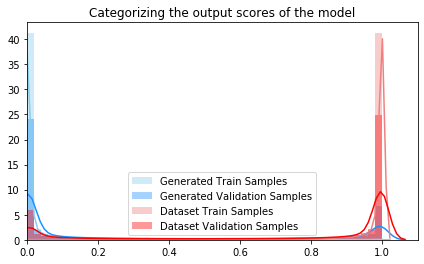

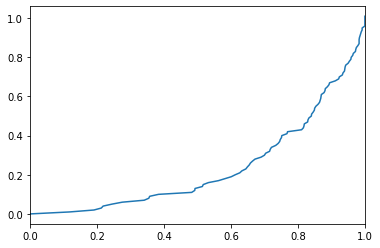

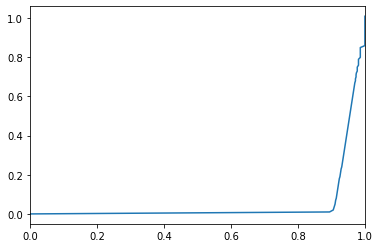

 49%|████▉     | 465642/946094 [1:06:46<50:59:10,  2.62it/s]

Training AUC at epoch 42: 0.04942727272727273
Validation AUC epoch 42: 0.23696363636363638
Training Accuracy at epoch 42: 97.3328
Validation Accuracy epoch 42: 71.26185882352941


 54%|█████▍    | 515605/946094 [1:13:15<51:39, 138.87it/s]  

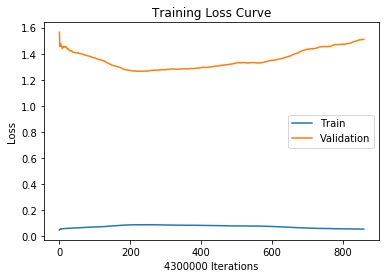

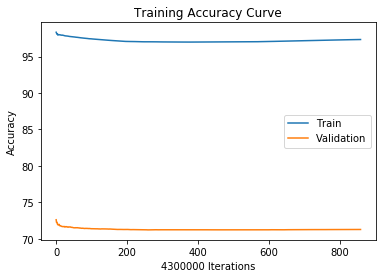

 54%|█████▍    | 515605/946094 [1:13:30<51:39, 138.87it/s]

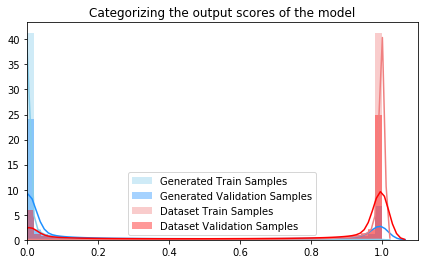

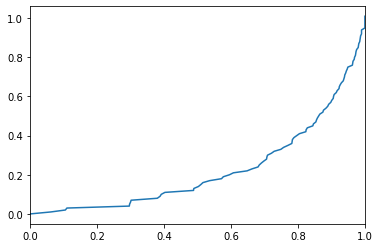

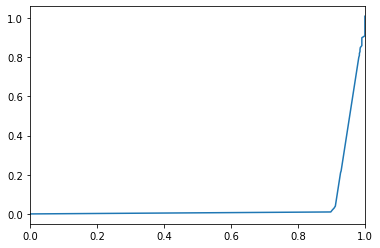

 55%|█████▍    | 515642/946094 [1:13:45<40:03:49,  2.98it/s]

Training AUC at epoch 42: 0.04988181818181818
Validation AUC epoch 42: 0.22373636363636362
Training Accuracy at epoch 42: 97.34151162790698
Validation Accuracy epoch 42: 71.26258139534883


 55%|█████▍    | 518600/946094 [1:14:09<1:23:33, 85.26it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████   | 665619/946094 [1:35:16<33:40, 138.81it/s] 

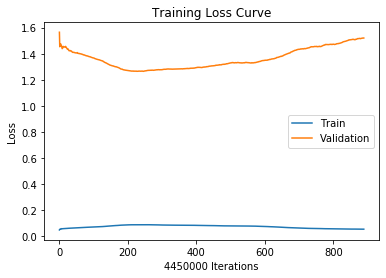

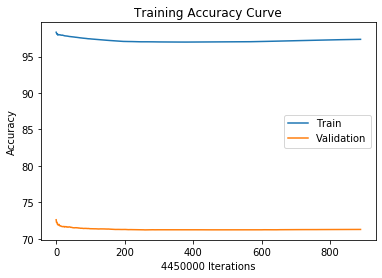

 70%|███████   | 665619/946094 [1:35:30<33:40, 138.81it/s]

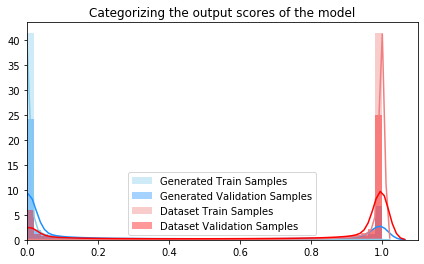

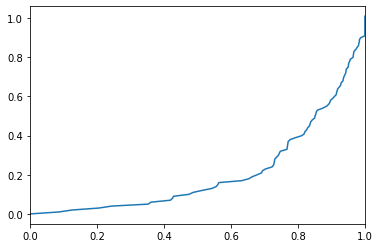

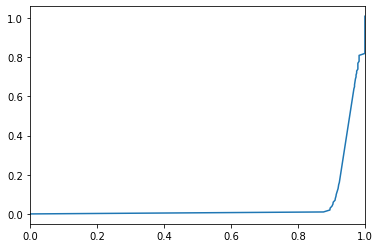

 70%|███████   | 665642/946094 [1:35:46<100:16:48,  1.29s/it]

Training AUC at epoch 42: 0.049481818181818175
Validation AUC epoch 42: 0.2090727272727273
Training Accuracy at epoch 42: 97.3665393258427
Validation Accuracy epoch 42: 71.26743820224719


 73%|███████▎  | 690448/946094 [1:39:02<28:59, 146.93it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 86%|████████▌ | 815622/946094 [1:57:12<15:51, 137.18it/s]

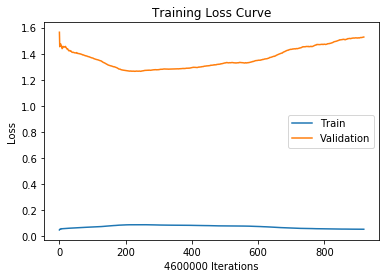

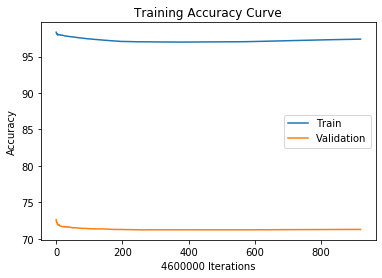

 86%|████████▌ | 815622/946094 [1:57:31<15:51, 137.18it/s]

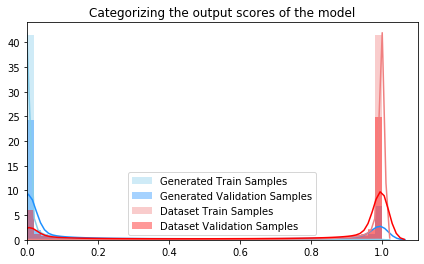

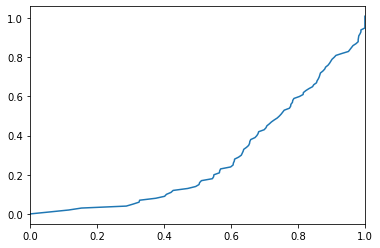

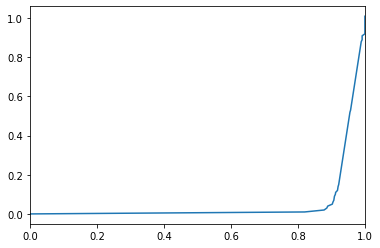

 86%|████████▌ | 815641/946094 [1:57:44<121:15:55,  3.35s/it]

Training AUC at epoch 42: 0.05234545454545454
Validation AUC epoch 42: 0.28555454545454545
Training Accuracy at epoch 42: 97.39321739130435
Validation Accuracy epoch 42: 71.26902173913044


 90%|█████████ | 855856/946094 [2:03:02<09:22, 160.40it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 915616/946094 [2:11:23<03:22, 150.20it/s]

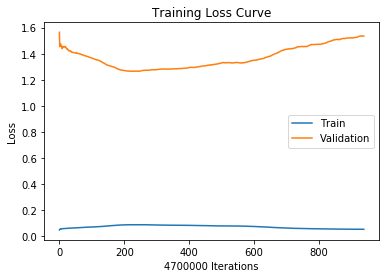

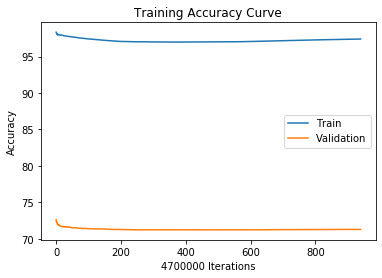

 97%|█████████▋| 915616/946094 [2:11:41<03:22, 150.20it/s]

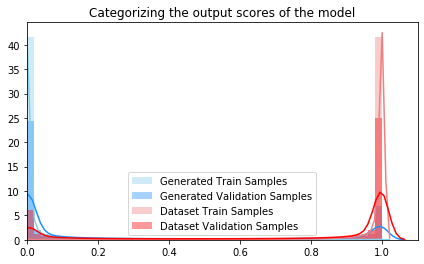

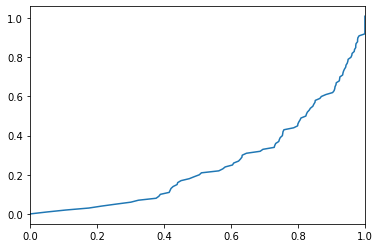

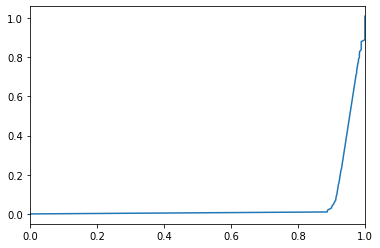

 97%|█████████▋| 915645/946094 [2:11:56<7:16:31,  1.16it/s] 

Training AUC at epoch 42: 0.05031818181818181
Validation AUC epoch 42: 0.2566272727272727
Training Accuracy at epoch 42: 97.40825531914894
Validation Accuracy epoch 42: 71.26940425531915


  0%|          | 17/946094 [00:00<1:36:55, 162.67it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 43  with learning rate:  [0.09000000000000001]


  2%|▏         | 19521/946094 [02:33<2:05:45, 122.81it/s]

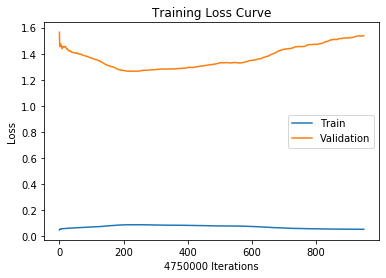

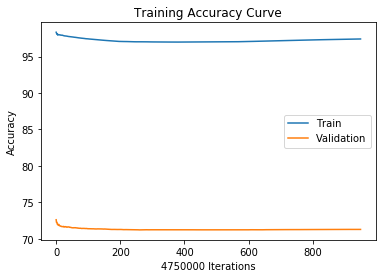

  2%|▏         | 19521/946094 [02:50<2:05:45, 122.81it/s]

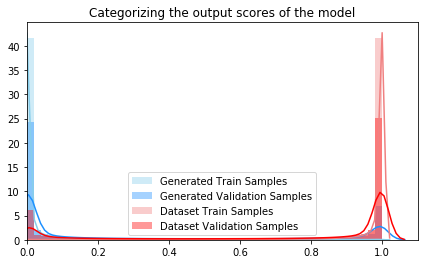

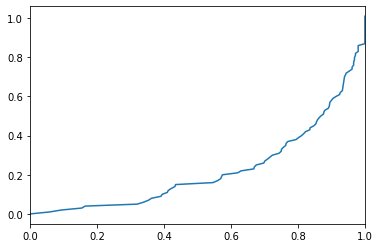

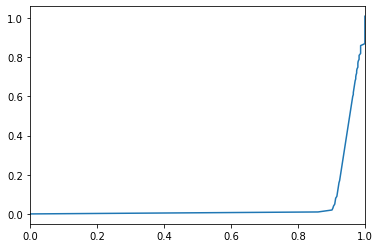

  2%|▏         | 19548/946094 [03:05<194:30:06,  1.32it/s]

Training AUC at epoch 43: 0.049945454545454536
Validation AUC epoch 43: 0.2222818181818182
Training Accuracy at epoch 43: 97.41606315789474
Validation Accuracy epoch 43: 71.27111578947368


  7%|▋         | 69527/946094 [09:34<1:27:06, 167.72it/s] 

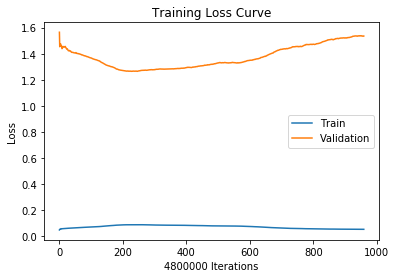

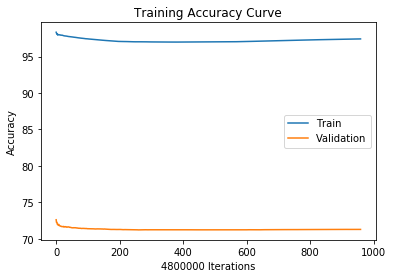

  7%|▋         | 69527/946094 [09:50<1:27:06, 167.72it/s]

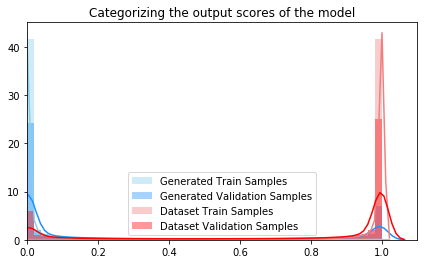

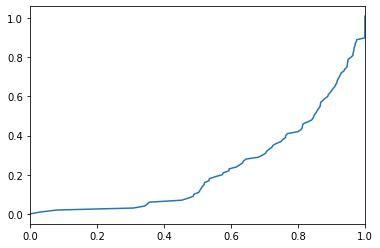

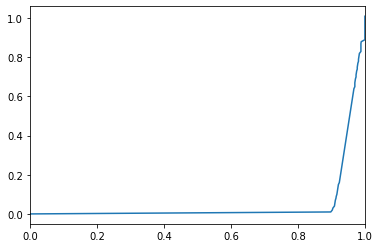

  7%|▋         | 69548/946094 [10:06<545:12:18,  2.24s/it]

Training AUC at epoch 43: 0.04983636363636364
Validation AUC epoch 43: 0.2311909090909091
Training Accuracy at epoch 43: 97.42364583333334
Validation Accuracy epoch 43: 71.27197916666667


 13%|█▎        | 119515/946094 [16:34<1:40:24, 137.19it/s]

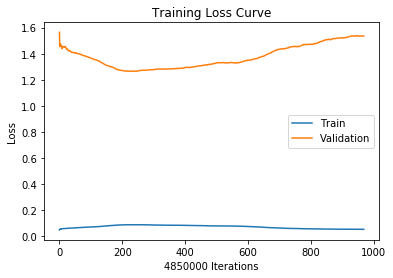

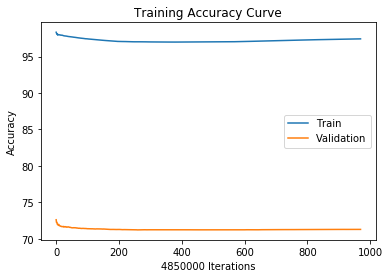

 13%|█▎        | 119515/946094 [16:50<1:40:24, 137.19it/s]

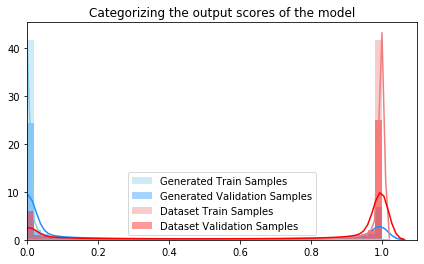

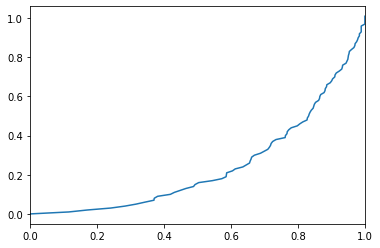

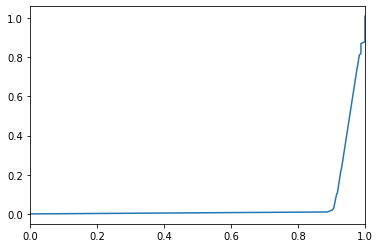

 13%|█▎        | 119548/946094 [17:09<111:15:13,  2.06it/s]

Training AUC at epoch 43: 0.04983636363636364
Validation AUC epoch 43: 0.24447272727272726
Training Accuracy at epoch 43: 97.43098969072165
Validation Accuracy epoch 43: 71.27379381443299


 18%|█▊        | 169511/946094 [23:35<2:21:14, 91.64it/s]  

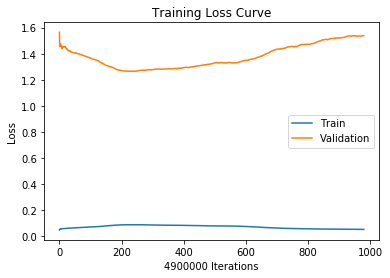

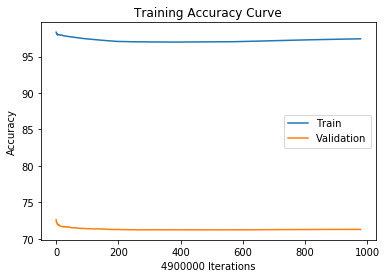

 18%|█▊        | 169511/946094 [23:50<2:21:14, 91.64it/s]

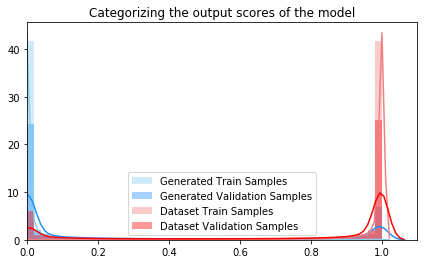

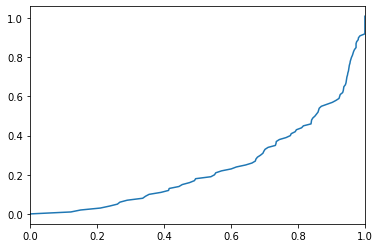

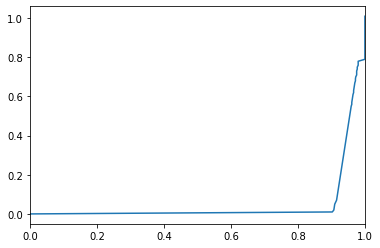

 18%|█▊        | 169548/946094 [24:08<80:40:25,  2.67it/s] 

Training AUC at epoch 43: 0.04804545454545455
Validation AUC epoch 43: 0.2388909090909091
Training Accuracy at epoch 43: 97.44020408163266
Validation Accuracy epoch 43: 71.27338775510204


 23%|██▎       | 219517/946094 [30:33<1:17:29, 156.28it/s]

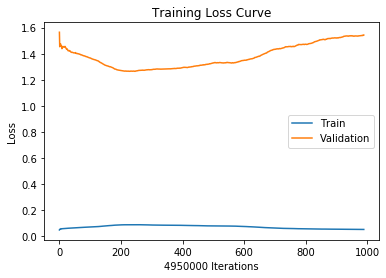

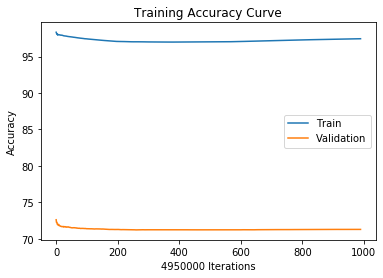

 23%|██▎       | 219517/946094 [30:50<1:17:29, 156.28it/s]

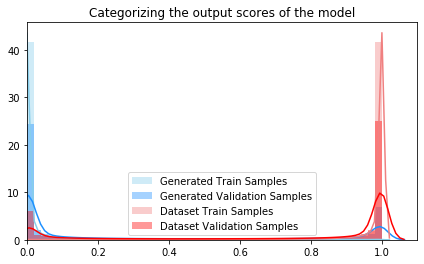

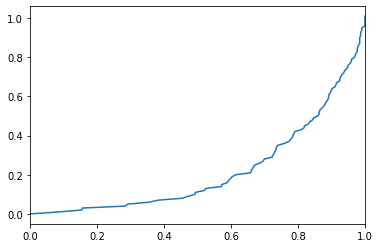

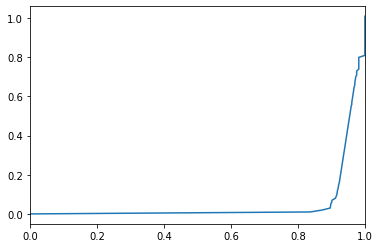

 23%|██▎       | 219530/946094 [31:08<161:08:16,  1.25it/s]

Training AUC at epoch 43: 0.05003636363636364
Validation AUC epoch 43: 0.2193
Training Accuracy at epoch 43: 97.44894949494949
Validation Accuracy epoch 43: 71.27282828282829


 28%|██▊       | 269529/946094 [37:45<1:16:06, 148.17it/s] 

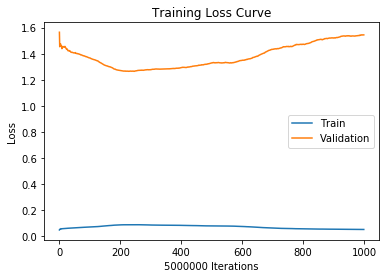

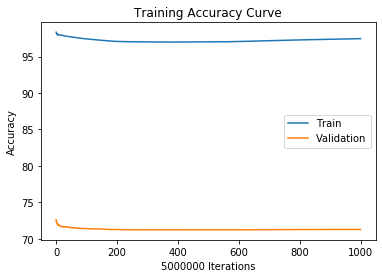

 28%|██▊       | 269529/946094 [38:00<1:16:06, 148.17it/s]

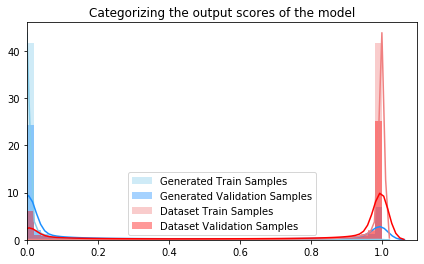

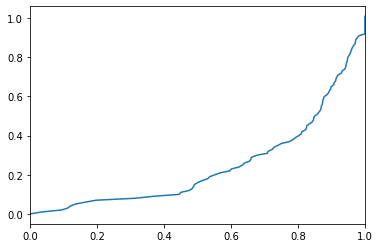

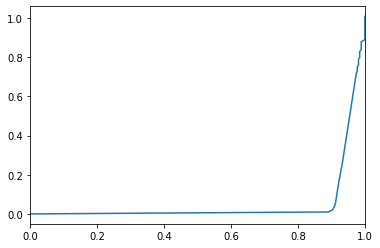

 28%|██▊       | 269548/946094 [38:18<1316:07:20,  7.00s/it]

Training AUC at epoch 43: 0.04983636363636363
Validation AUC epoch 43: 0.24574545454545454
Training Accuracy at epoch 43: 97.45642
Validation Accuracy epoch 43: 71.27046


 34%|███▍      | 319510/946094 [44:50<1:00:10, 173.57it/s]  

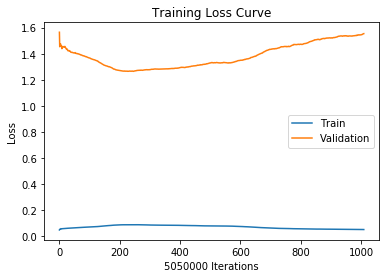

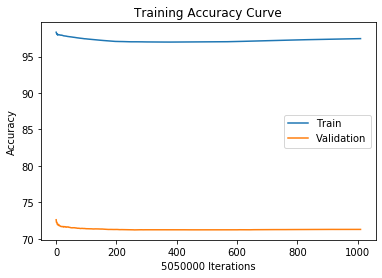

 34%|███▍      | 319510/946094 [45:10<1:00:10, 173.57it/s]

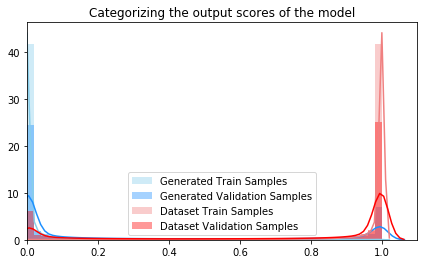

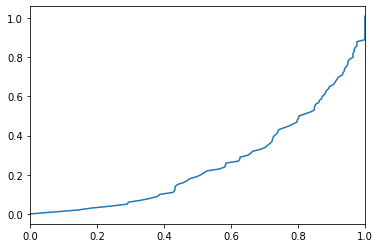

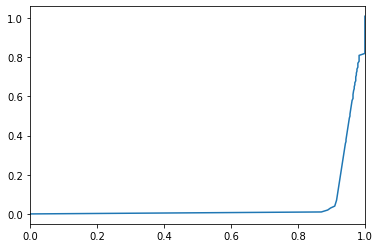

 34%|███▍      | 319543/946094 [45:26<65:03:05,  2.68it/s]

Training AUC at epoch 43: 0.04907272727272727
Validation AUC epoch 43: 0.2582272727272727
Training Accuracy at epoch 43: 97.46384158415842
Validation Accuracy epoch 43: 71.27229702970297


 39%|███▉      | 369528/946094 [51:55<1:03:28, 151.37it/s]

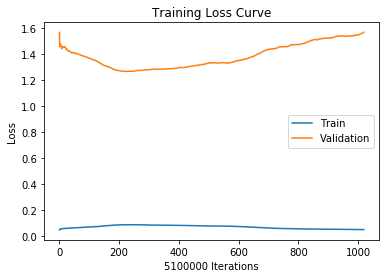

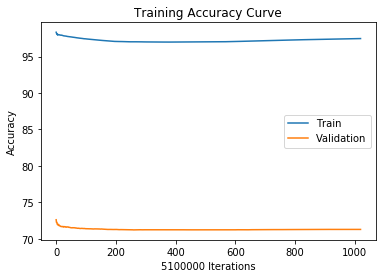

 39%|███▉      | 369528/946094 [52:10<1:03:28, 151.37it/s]

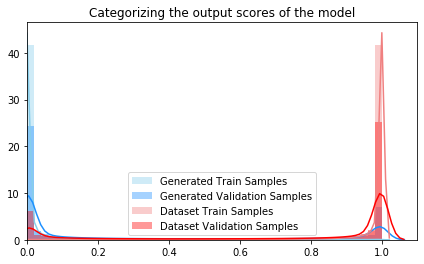

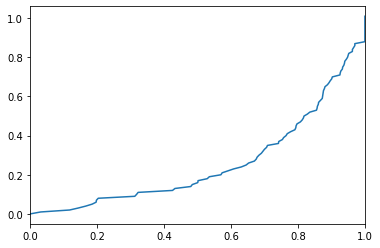

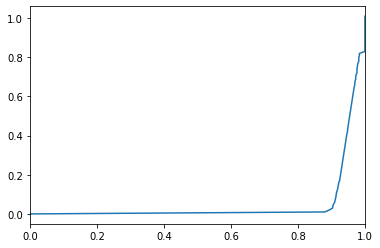

 39%|███▉      | 369548/946094 [52:30<585:27:13,  3.66s/it]

Training AUC at epoch 43: 0.049563636363636365
Validation AUC epoch 43: 0.25666363636363637
Training Accuracy at epoch 43: 97.47156862745098
Validation Accuracy epoch 43: 71.27096078431373


 44%|████▍     | 419511/946094 [59:04<1:23:36, 104.98it/s] 

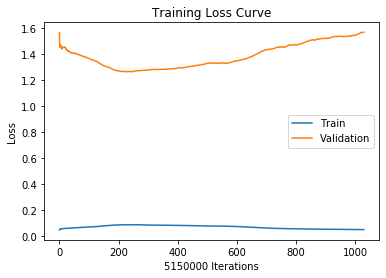

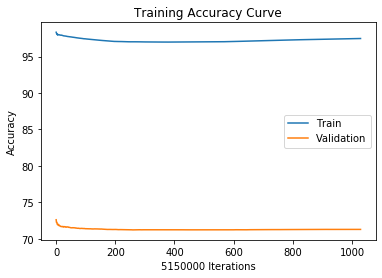

 44%|████▍     | 419511/946094 [59:20<1:23:36, 104.98it/s]

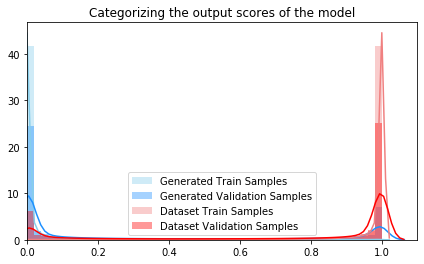

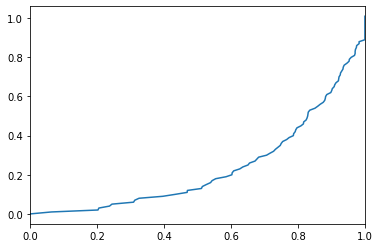

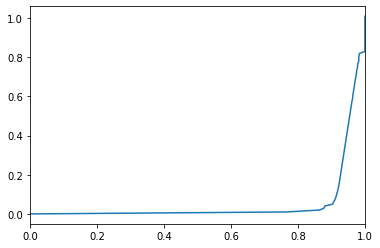

 44%|████▍     | 419546/946094 [59:39<57:27:12,  2.55it/s]

Training AUC at epoch 43: 0.051481818181818184
Validation AUC epoch 43: 0.23464545454545455
Training Accuracy at epoch 43: 97.47953398058253
Validation Accuracy epoch 43: 71.27285436893204


 50%|████▉     | 469529/946094 [1:06:21<48:02, 165.34it/s]  

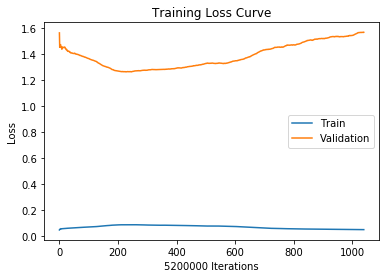

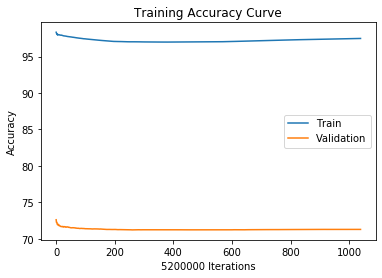

 50%|████▉     | 469529/946094 [1:06:40<48:02, 165.34it/s]

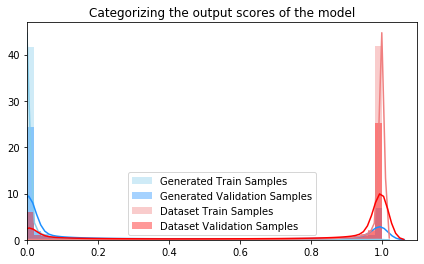

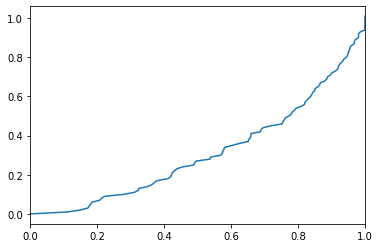

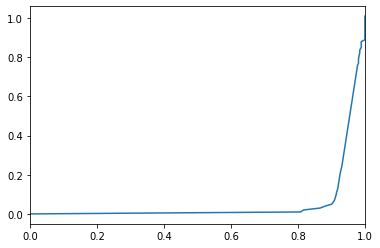

 50%|████▉     | 469548/946094 [1:06:58<1017:32:39,  7.69s/it]

Training AUC at epoch 43: 0.0527
Validation AUC epoch 43: 0.3113727272727273
Training Accuracy at epoch 43: 97.48707692307693
Validation Accuracy epoch 43: 71.2724423076923


 55%|█████▍    | 519513/946094 [1:13:26<51:39, 137.63it/s]    

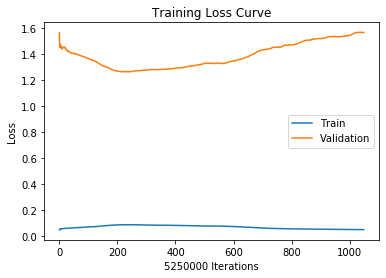

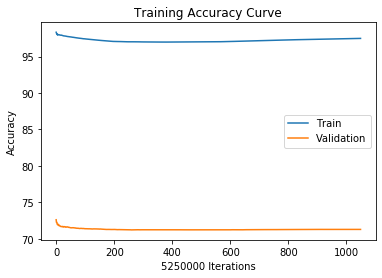

 55%|█████▍    | 519513/946094 [1:13:40<51:39, 137.63it/s]

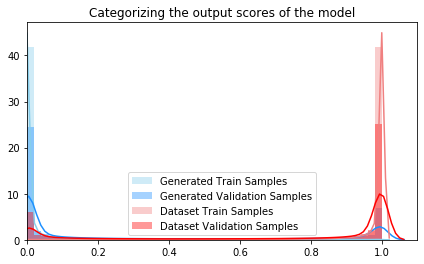

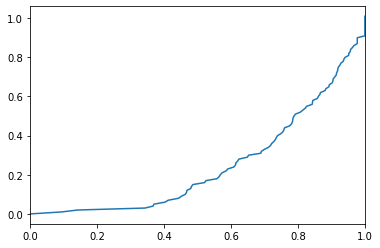

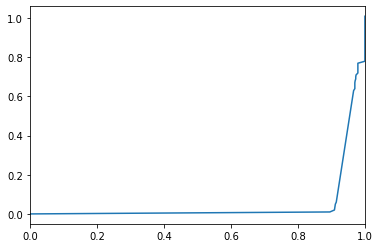

 55%|█████▍    | 519548/946094 [1:14:02<53:11:31,  2.23it/s]

Training AUC at epoch 43: 0.04771818181818181
Validation AUC epoch 43: 0.2473545454545454
Training Accuracy at epoch 43: 97.49415238095239
Validation Accuracy epoch 43: 71.27184761904762


 60%|██████    | 569512/946094 [1:20:29<1:11:03, 88.32it/s] 

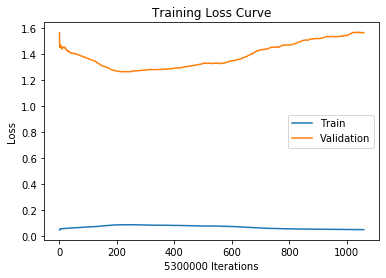

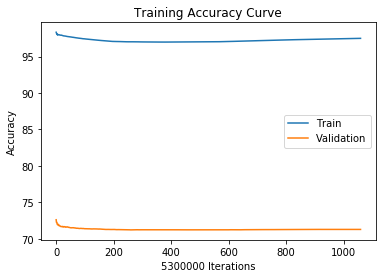

 60%|██████    | 569512/946094 [1:20:40<1:11:03, 88.32it/s]

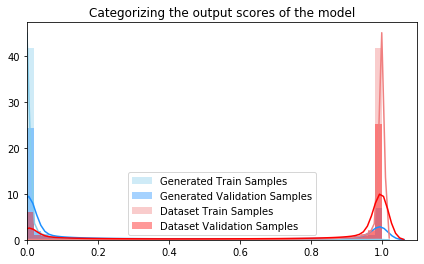

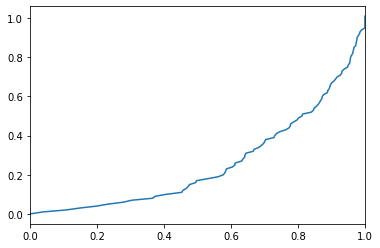

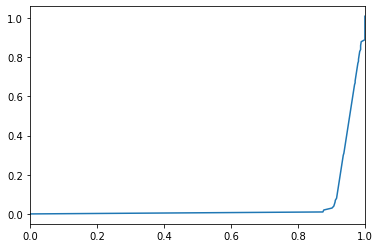

 60%|██████    | 569548/946094 [1:21:05<44:00:13,  2.38it/s]

Training AUC at epoch 43: 0.050527272727272726
Validation AUC epoch 43: 0.25637272727272725
Training Accuracy at epoch 43: 97.5014716981132
Validation Accuracy epoch 43: 71.27028301886793


 65%|██████▌   | 619522/946094 [1:27:36<34:34, 157.43it/s]  

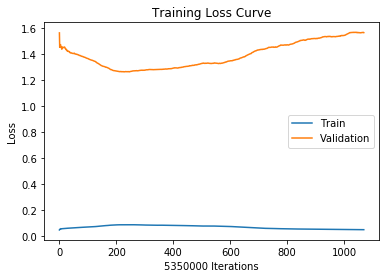

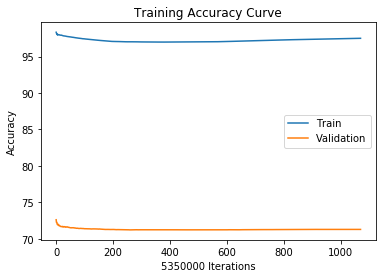

 65%|██████▌   | 619522/946094 [1:27:50<34:34, 157.43it/s]

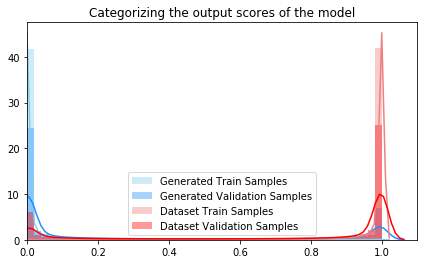

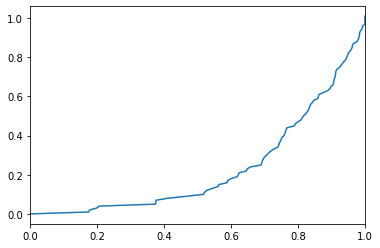

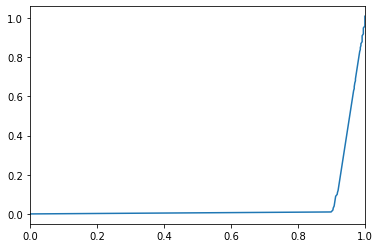

 65%|██████▌   | 619530/946094 [1:28:13<125:57:25,  1.39s/it]

Training AUC at epoch 43: 0.050290909090909094
Validation AUC epoch 43: 0.23265454545454545
Training Accuracy at epoch 43: 97.508
Validation Accuracy epoch 43: 71.2718878504673


 71%|███████   | 669516/946094 [1:34:46<38:25, 119.99it/s]   

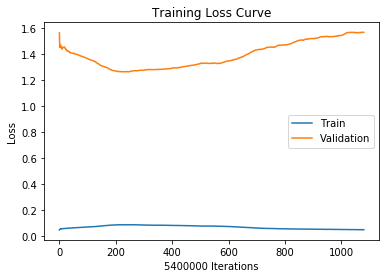

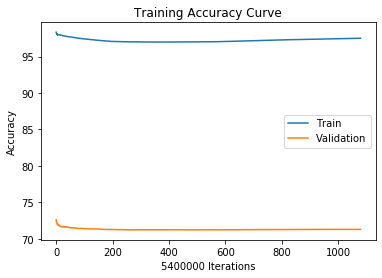

 71%|███████   | 669516/946094 [1:35:00<38:25, 119.99it/s]

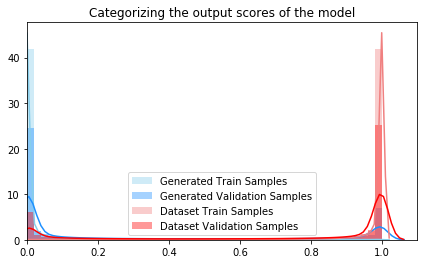

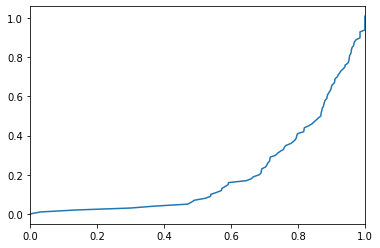

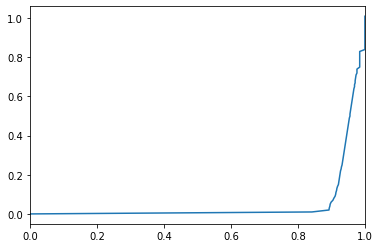

 71%|███████   | 669546/946094 [1:35:22<42:50:02,  1.79it/s]

Training AUC at epoch 43: 0.0505909090909091
Validation AUC epoch 43: 0.20527272727272727
Training Accuracy at epoch 43: 97.5155
Validation Accuracy epoch 43: 71.27333333333333


 76%|███████▌  | 719520/946094 [1:42:43<45:43, 82.60it/s]   

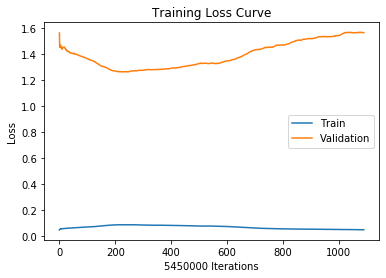

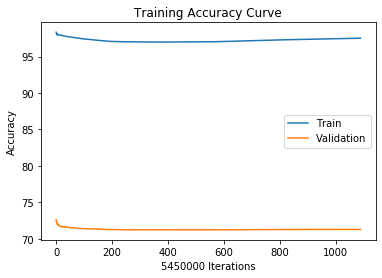

 76%|███████▌  | 719520/946094 [1:43:00<45:43, 82.60it/s]

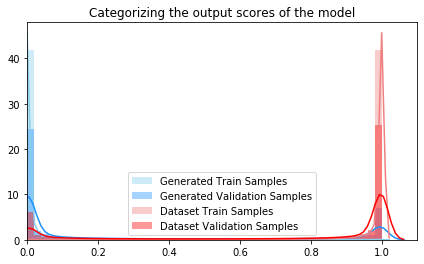

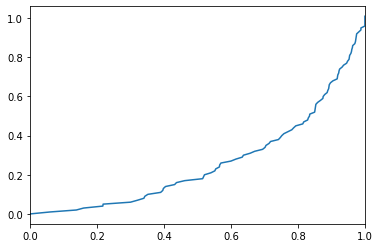

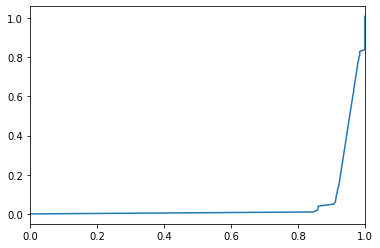

 76%|███████▌  | 719542/946094 [1:43:21<50:14:25,  1.25it/s]

Training AUC at epoch 43: 0.05118181818181819
Validation AUC epoch 43: 0.2616818181818182
Training Accuracy at epoch 43: 97.5219633027523
Validation Accuracy epoch 43: 71.27152293577981


 81%|████████▏ | 769524/946094 [1:49:55<19:37, 149.96it/s]  

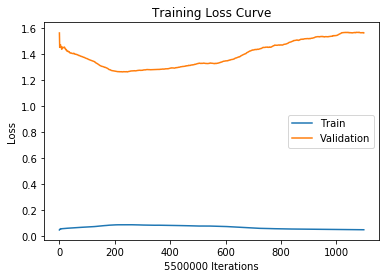

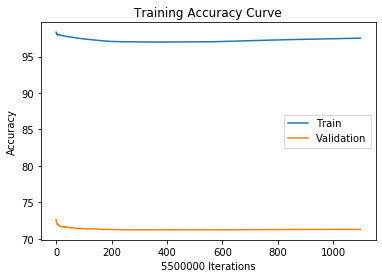

 81%|████████▏ | 769524/946094 [1:50:11<19:37, 149.96it/s]

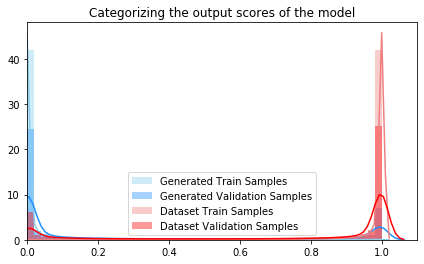

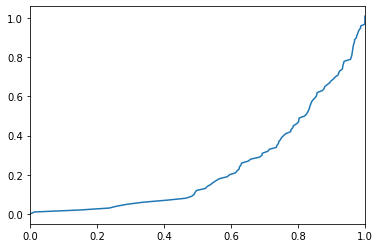

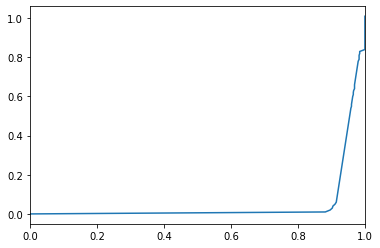

 81%|████████▏ | 769547/946094 [1:50:32<63:21:46,  1.29s/it]

Training AUC at epoch 43: 0.049309090909090914
Validation AUC epoch 43: 0.24118181818181814
Training Accuracy at epoch 43: 97.52863636363637
Validation Accuracy epoch 43: 71.27398181818182


 87%|████████▋ | 819512/946094 [1:57:08<20:11, 104.48it/s]  

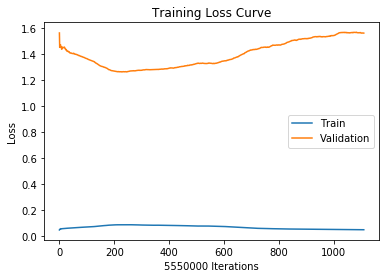

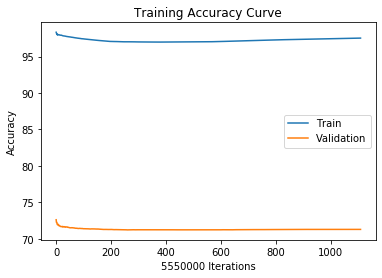

 87%|████████▋ | 819512/946094 [1:57:21<20:11, 104.48it/s]

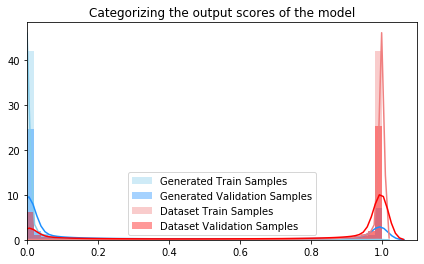

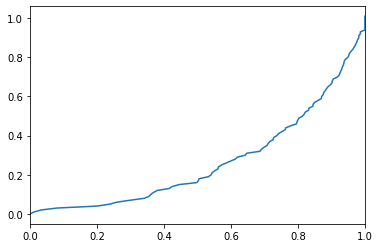

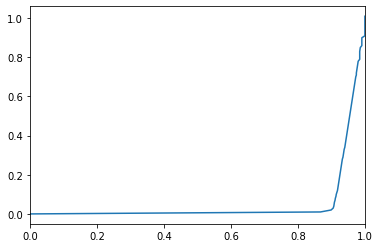

 87%|████████▋ | 819548/946094 [1:57:46<15:45:45,  2.23it/s]

Training AUC at epoch 43: 0.05071818181818182
Validation AUC epoch 43: 0.26645454545454544
Training Accuracy at epoch 43: 97.53517117117117
Validation Accuracy epoch 43: 71.27392792792793


 92%|█████████▏| 869523/946094 [2:04:27<07:42, 165.43it/s]  

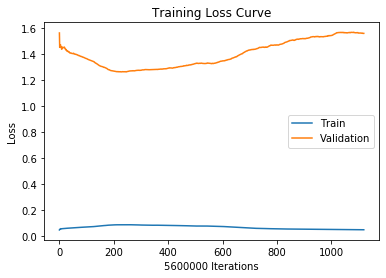

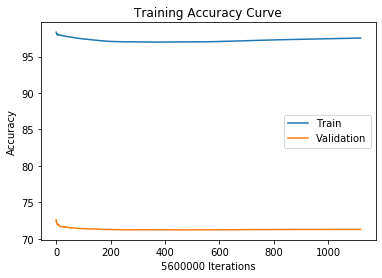

 92%|█████████▏| 869523/946094 [2:04:41<07:42, 165.43it/s]

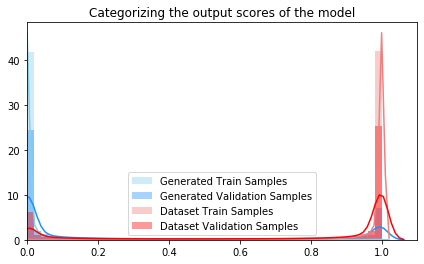

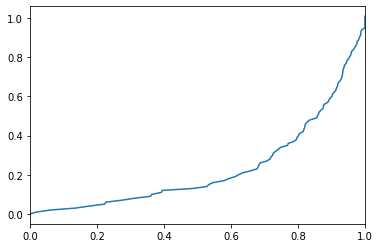

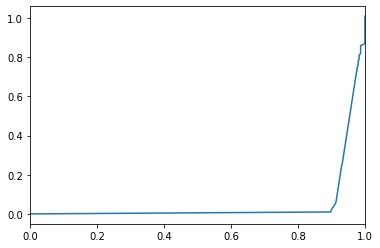

 92%|█████████▏| 869548/946094 [2:05:06<25:15:17,  1.19s/it]

Training AUC at epoch 43: 0.049600000000000005
Validation AUC epoch 43: 0.23177272727272727
Training Accuracy at epoch 43: 97.54246428571429
Validation Accuracy epoch 43: 71.27553571428571


 97%|█████████▋| 919521/946094 [2:11:43<03:13, 137.56it/s]  

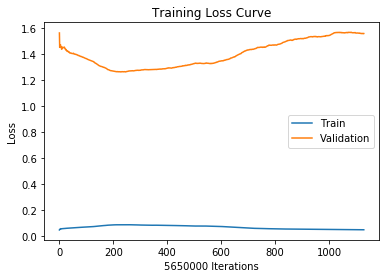

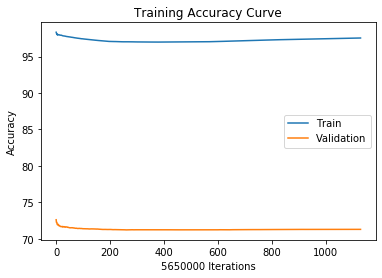

 97%|█████████▋| 919521/946094 [2:12:01<03:13, 137.56it/s]

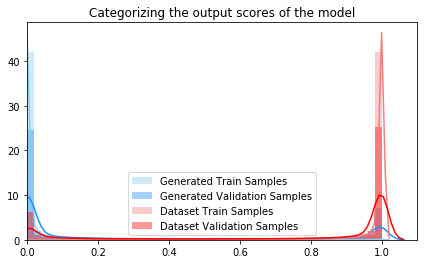

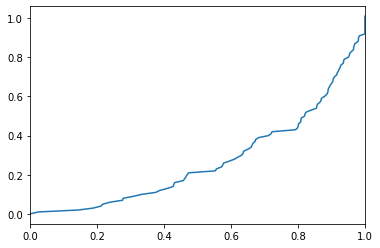

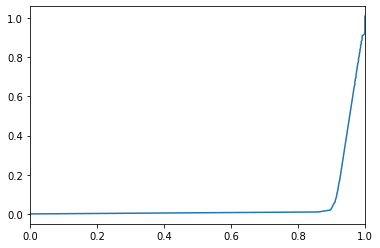

 97%|█████████▋| 919546/946094 [2:12:21<6:38:18,  1.11it/s]

Training AUC at epoch 43: 0.05068181818181818
Validation AUC epoch 43: 0.2719636363636364
Training Accuracy at epoch 43: 97.5493628318584
Validation Accuracy epoch 43: 71.27876106194691


  0%|          | 17/946094 [00:00<1:36:27, 163.48it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 44  with learning rate:  [0.07290000000000002]


  2%|▏         | 23419/946094 [03:08<2:48:58, 91.01it/s] 

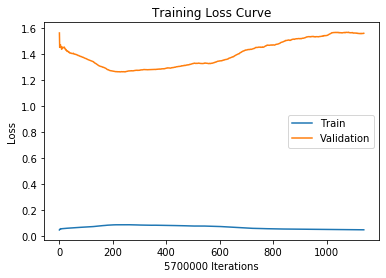

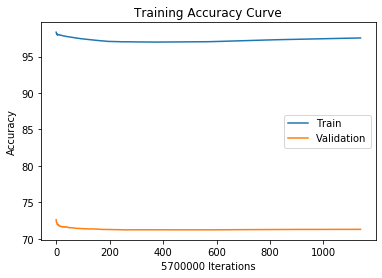

  2%|▏         | 23419/946094 [03:20<2:48:58, 91.01it/s]

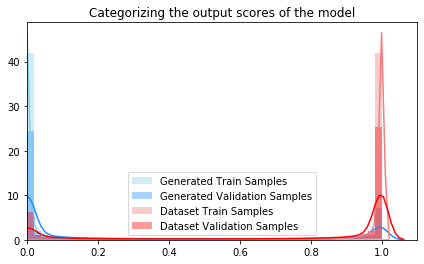

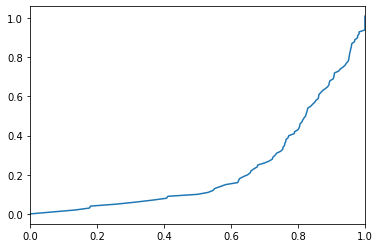

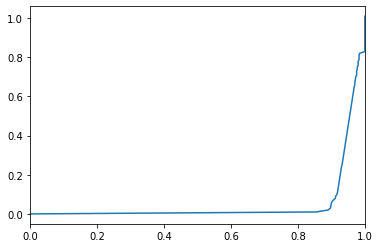

  2%|▏         | 23454/946094 [03:47<127:27:02,  2.01it/s]

Training AUC at epoch 44: 0.05018181818181818
Validation AUC epoch 44: 0.22972727272727272
Training Accuracy at epoch 44: 97.5568245614035
Validation Accuracy epoch 44: 71.27963157894737


  8%|▊         | 73422/946094 [10:22<1:32:22, 157.45it/s] 

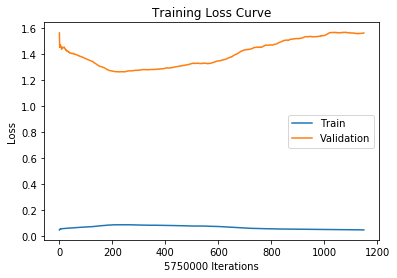

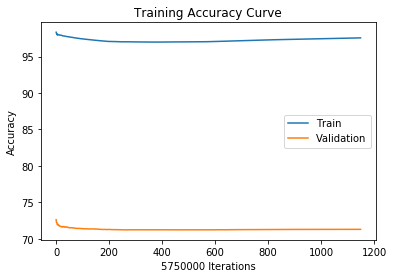

  8%|▊         | 73422/946094 [10:40<1:32:22, 157.45it/s]

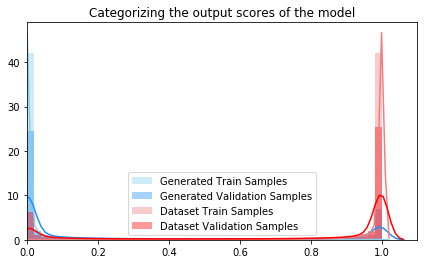

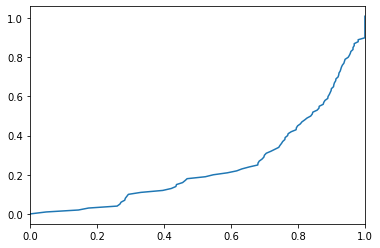

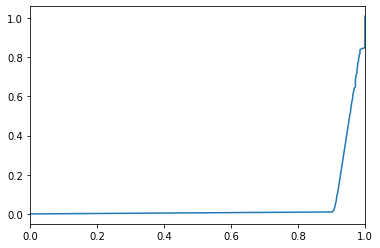

  8%|▊         | 73436/946094 [11:02<208:23:01,  1.16it/s]

Training AUC at epoch 44: 0.04891818181818182
Validation AUC epoch 44: 0.24821818181818184
Training Accuracy at epoch 44: 97.56605217391305
Validation Accuracy epoch 44: 71.28189565217392


 13%|█▎        | 123427/946094 [17:34<1:50:29, 124.09it/s]

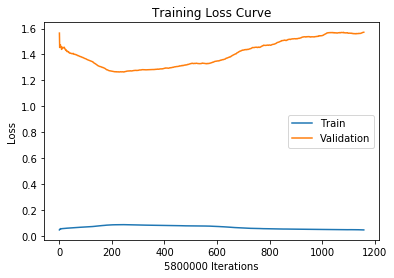

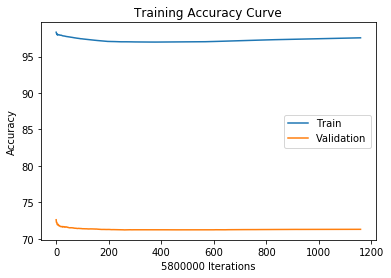

 13%|█▎        | 123427/946094 [17:50<1:50:29, 124.09it/s]

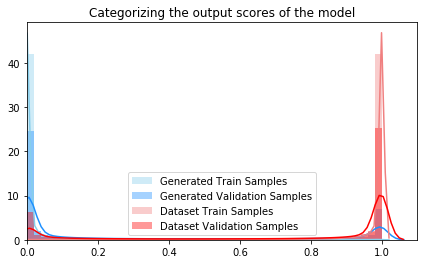

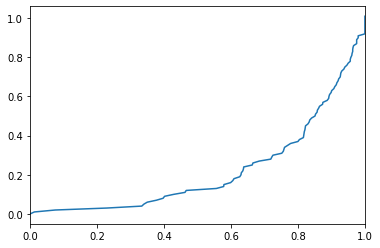

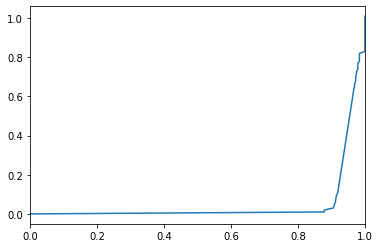

 13%|█▎        | 123454/946094 [18:15<215:50:04,  1.06it/s]

Training AUC at epoch 44: 0.04933636363636364
Validation AUC epoch 44: 0.22089999999999999
Training Accuracy at epoch 44: 97.57494827586207
Validation Accuracy epoch 44: 71.28368965517241


 18%|█▊        | 173423/946094 [24:49<2:17:51, 93.41it/s]  

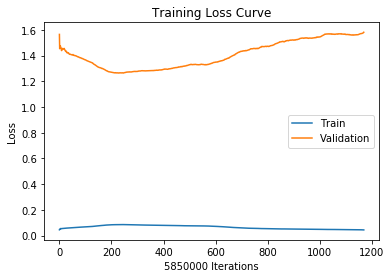

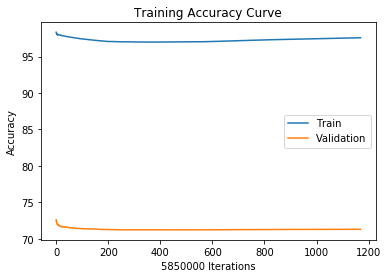

 18%|█▊        | 173423/946094 [25:00<2:17:51, 93.41it/s]

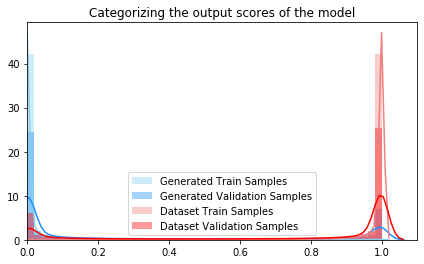

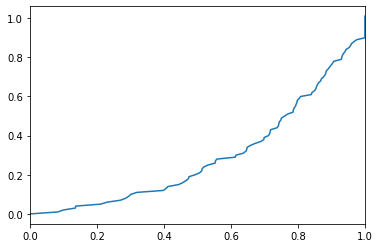

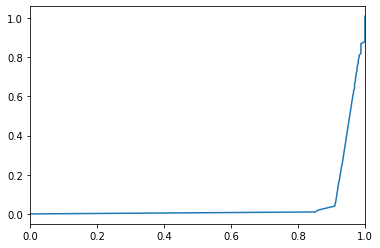

 18%|█▊        | 173453/946094 [25:30<144:35:52,  1.48it/s]

Training AUC at epoch 44: 0.050754545454545455
Validation AUC epoch 44: 0.2948727272727273
Training Accuracy at epoch 44: 97.58335042735042
Validation Accuracy epoch 44: 71.28642735042735


 24%|██▎       | 223415/946094 [32:07<1:21:26, 147.89it/s] 

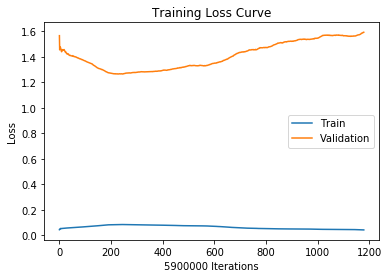

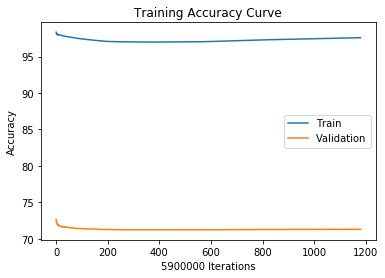

 24%|██▎       | 223415/946094 [32:20<1:21:26, 147.89it/s]

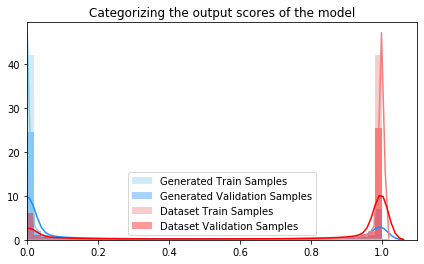

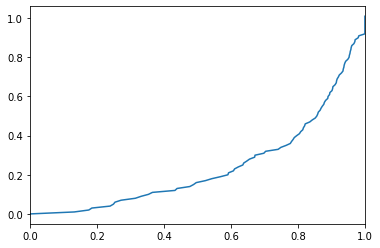

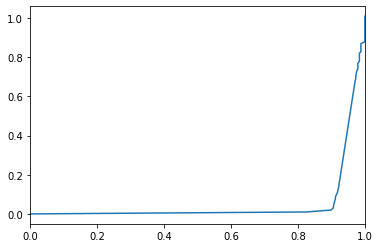

 24%|██▎       | 223453/946094 [32:49<84:02:21,  2.39it/s] 

Training AUC at epoch 44: 0.05042727272727272
Validation AUC epoch 44: 0.2403818181818182
Training Accuracy at epoch 44: 97.59172881355933
Validation Accuracy epoch 44: 71.28708474576271


 29%|██▉       | 273424/946094 [39:33<1:43:51, 107.95it/s]

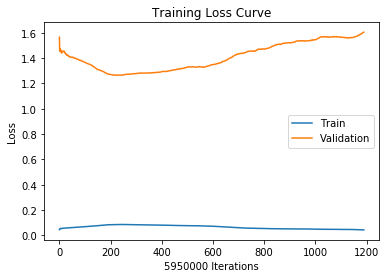

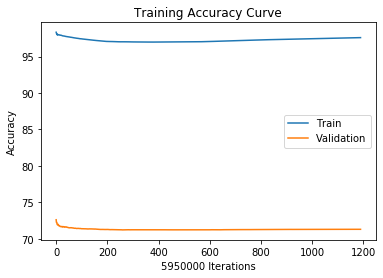

 29%|██▉       | 273424/946094 [39:50<1:43:51, 107.95it/s]

In [ ]:
model = SingleAlphabetComplexNet()
model_name = model.name
model_id = "06172020"
model.to(device)
checkpoint = 'model_checkpoints/binary/%s/06172020.pth' % model_name
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
single_alphabet = True
cdf=False
NUM_EPOCHS = 50
BATCH_SIZE = 128
gamma = 1e-1
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path, cdf=cdf)